# Generating Molecules

## Prerequisite
RDkit - https://www.rdkit.org/docs/Install.html

SELFIES -  https://github.com/aspuru-guzik-group/selfies

SYBA - https://github.com/lich-uct/syba

## Experiment Imports / Functions: 

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import pickle


import time 
import selfies
import rdkit
import random
import numpy as np
import random
from rdkit import Chem
from selfies import encoder, decoder
from rdkit.Chem import MolFromSmiles as smi2mol
from rdkit.Chem import AllChem
from rdkit.DataStructs.cDataStructs import TanimotoSimilarity
from rdkit.Chem import Mol
from rdkit.Chem.AtomPairs.Sheridan import GetBPFingerprint, GetBTFingerprint
from rdkit.Chem.Pharm2D import Generate, Gobbi_Pharm2D
from rdkit.Chem import Draw

from rdkit.Chem import MolToSmiles as mol2smi
from rdkit import RDLogger
RDLogger.DisableLog('rdApp.*')

import Stoned

## Parent Molecules

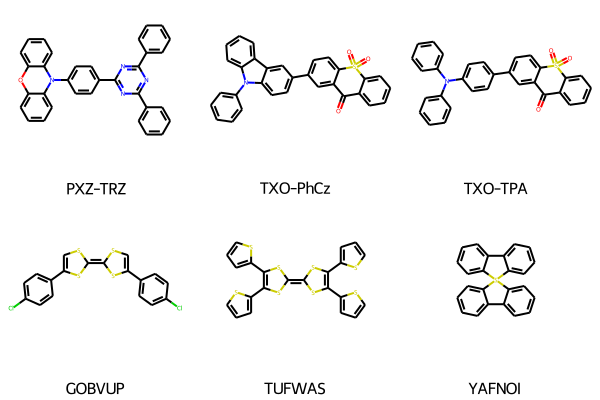

In [3]:
#insert smi with name here
smi_dict = {'PXZ-TRZ': 'c7ccc(c6nc(c1ccccc1)nc(c5ccc(n4c2ccccc2oc3ccccc34)cc5)n6)cc7',
            'TXO-PhCz':'O=C6c1ccccc1S(=O)(=O)c7ccc(c2ccc4c(c2)c3ccccc3n4c5ccccc5)cc67',
            'TXO-TPA':'O=C5c1ccccc1S(=O)(=O)c6ccc(c4ccc(N(c2ccccc2)c3ccccc3)cc4)cc56',
            'GOBVUP':'Clc4ccc(c3csc(=c2scc(c1ccc(Cl)cc1)s2)s3)cc4',
            'TUFWAS':'c6csc(c4sc(=c3sc(c1cccs1)c(c2cccs2)s3)sc4c5cccs5)c6',
            'YAFNOI':'c1ccc3c(c1)c2ccccc2S36c4ccccc4c5ccccc56'}

# save dictionary to use for "Generate_molecules-analysis"
pickle.dump(smi_dict, open("Mol_list_to_mutate.pkl",'wb'))
# converting smiles -> molecule
mols = [Chem.MolFromSmiles(smi) for smi in smi_dict.values()]
legends = [name for name in smi_dict.keys()]
img=Draw.MolsToGridImage(mols,molsPerRow=3,legends=legends) 
img

# Poputation test on mutation

Make sure the loop is efficient 

In [ ]:
MoleculeLibrary = {}
MoleculeLibraryCanon = {}

for ParentMolName, ParentMolSmiles in smi_dict.items():

    total_time = time.time() 
    #number of molecules to generate
    num_random_samples = 10000 
    #number of mutations to perform on each SELFIES within 'selfies_ls'
    num_mutation    = 1

    mol = Chem.MolFromSmiles(ParentMolSmiles)
    if mol == None: 
        raise Exception('Invalid starting structure encountered')

    start_time = time.time()
    # # Returns a random (dearomatized) SMILES given an rdkit mol object of a molecule
    randomized_smile_orderings  = [Stoned.randomize_smiles(mol) for _ in range(num_random_samples)]

    # # Convert all the molecules to SELFIES
    selfies_ls = [encoder(x) for x in randomized_smile_orderings]
    print('Randomized molecules (in SELFIES) time: ', time.time()-start_time, 'seconds')


    all_smiles_collect = []

    start_time = time.time()

    # Mutate the SELFIES: 
    selfies_mut = Stoned.get_mutated_SELFIES(selfies_ls.copy(), num_mutations=num_mutation)
    print(len(selfies_mut), 'generated with', num_mutation, 'mutation(s)')
    # Convert back to SMILES: 
    smiles_back = [decoder(x) for x in selfies_mut]
    all_smiles_collect = all_smiles_collect + smiles_back


    print('Mutation obtainment time (back to smiles): ', time.time()-start_time, 'seconds')


    # Work on:  all_smiles_collect
    start_time = time.time()
    canon_smi_ls = []
    for item in all_smiles_collect: 
        # Return a canonical smile representation of smi
        mol, smi_canon, did_convert = Stoned.sanitize_smiles(item)
        if mol == None or smi_canon == '' or did_convert == False: 
            raise Exception('Invalid smile string found')
        canon_smi_ls.append(smi_canon)
    canon_smi_ls        = list(set(canon_smi_ls)) # change name to unique
    
    MoleculeLibraryCanon[ParentMolName] = canon_smi_ls
    MoleculeLibrary[ParentMolName] = all_smiles_collect
    
    print('Unique mutated structure obtainment time: ', time.time()-start_time, 'seconds')

    print('total unique structures obtained:', len(canon_smi_ls), 'out of', len(all_smiles_collect), 'total generated')
    
# Save MoleculeLibraryCanon and MoleculeLibrary to be used for the next 
df = pd.DataFrame(MoleculeLibraryCanon)
df.to_pickle("all_unique_smi_data.pkl")

df = pd.DataFrame(MoleculeLibrary)
df.to_pickle("all_smi_data.pkl")

## Exhaustive Search

### Caution:
The cell below is intended for testing exhaustive search and data generation purposes, but please be aware that it may require a substantial amount of time to complete.

In [1]:
# Single mutation per iteration
num_mutation_ls = [1] # just make it a 1 variable indead of a list if not used in future

data_mut = {}

for name, smi in smi_dict.items():
    data_mut[name] = {}
    step = 10000 # increase maximum number of population after each iteration
    start = 5000 # initial number of population to start with CHANGE this name to NUM_generated
    print(name)
        
    # Convert to SELFIES
    selfies_ls = [encoder(x) for x in [smi]]
    # loop until conversion (plateau of the unique number of SMILES generated)
    while(True):
        all_smiles_collect = {} # GENERATED SMILES rename
        
        start_time = time.time()           
        for num_mutations in num_mutation_ls:
            
            all_smiles_collect = []
            
            for num in range(0,start): # is this needed or just generate 1000000 and keep adding and note the "milestone" (number of unique generated)
                 # Mutate the SELFIES: 
                selfies_mut = get_mutated_SELFIES(selfies_ls.copy(), num_mutations=num_mutations)

                # Convert back to SMILES: 
                smiles_back = [decoder(x) for x in selfies_mut]
        
                all_smiles_collect.extend(smiles_back)
            
            # save the mutated list of SELFIES -> SMILES generated
            pkl_fname = name+"_"+str(num_mutations)+"_mutation_"+str(start)+"_all_smi_lists.pkl"
            pickle.dump(all_smiles_collect, open(pkl_fname,'wb'))
            
           
            # Work on:  all_smiles_collect
            canon_smi_ls = []
            for item in all_smiles_collect: 
                mol, smi_canon, did_convert = sanitize_smiles(item)
                if mol == None or smi_canon == '' or did_convert == False: 
                    print(smi_canon)
                    raise Exception('Invalid smile string found')
                canon_smi_ls.append(smi_canon)
            canon_smi_ls        = list(set(canon_smi_ls))
            print('Unique mutated structure obtainment time: ', time.time()-start_time)
            pkl_fname = name+"_"+str(num_mutations)+"_mutation_"+str(start)+"_canon_smi_lists.pkl"
            pickle.dump(canon_smi_ls, open(pkl_fname,'wb'))
            
        data_mut[name][start] = len(set(all_smiles_collect))

        if start > step*3:
            if data_mut[name][start] == data_mut[name][start-(step*3)]:
                break
        start = start + step
df = pd.DataFrame(data_mut)
df.to_pickle("DataFrame_data_"+str(num_mutation_ls[0])+"_mutation.pkl")